# Anomaly Detection and Interpretation from Tabular Data Using Transformer Architecture

We present a novel approach to anomaly detection and interpretation from tabular data using a transformer
architecture. Our approach comprises two main components: the Anomaly Detector and the Anomaly Interpreter. 

#### Anomaly Detector:
The Anomaly Detector component functions as a supervised classification model, comprising a multi-layer bidirectional Transformer encoder and a subsequent binary classification layer. This model is trained using labeled tabular data to optimize performance, supported by advanced features such as a custom tokenizer and specialized embedding layers (token and positional embeddings) to enhance data understanding and processing.

Custom Tokenizer: We have developed a custom tokenizer specifically designed to prepare textual representations of tabular data for processing by transformer models. This tokenizer focuses on tokenizing, vocabulary mapping, and handling out-of-vocabulary items.

Embedding Layer: This layer converts each token from its tokenized form (i.e., discrete IDs) into a vector of fixed size (i.e., continuous vector representation). The embedding layer combines three types of embeddings to represent each token fully before it is processed by the subsequent layers of the model. 

Encoder Layers: The primary objective of encoder layers is to develop a deep, nuanced understanding of language context and semantics. Each layer processes input embeddings (combined token and positional embeddings) to build increasingly complex representations. 

Classification Layer: Pooling Layer. The output of the last encoder layer (corresponding to each token) is pooled to create a fixed-size output. Dense Layer. This is a fully connected neural network layer that maps the high-dimensional output of previous layer to two classes in our binary classification problem

#### Anomaly Interpreter: 
The objective of this component is to interpret anomalies within textual data transformed from tabular format using the trained transformer model.

Association Matrix: An association matrix 𝑀 captures the average attention between all pairs of tokens across
the normal training data. 

Extract Attention Weights: This module is designed to extract attention weights from the trained transformer model for a given input row.

Identify Closely Related Tokens: This module aims to find pairs of tokens in an input row that receive high attention weights, indicating a strong association according to the model’s attention mechanism.

Identify Violation Rules: After identifying high-attention pairs in a test row deemed anomalous, this module compare these pairs against the association matrix 𝑀 to identify rule violations based on a threshold value.

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch

/Users/uriel/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Step 1: Convert Tabular Data to Text

To address unique tabular data challenges, we developed a methodology to convert table rows of any data type into a sentence-like structure, enabling effective data processing by the transformer model. 

By converting each row of a CSV file into a sentence formatted as [column name: value], the tokenizer ensures that numeric values and their associated column names are treated as single tokens, thus preventing the splitting of numerical values during tokenization.

In [2]:
#source: https://odds.cs.stonybrook.edu/breast-cancer-wisconsin-original-dataset/
file_path = 'breast-cancer-wisconsin.csv'

df = pd.read_csv(file_path).drop('ID', axis=1) # Assuming the dataset has an 'ID' column
# df = pd.read_csv(file_path) 

def row_to_sentence(row):
    return ','.join([f'[{col}:{val}]' for col, val in row.items()])

df['sentence'] = df.drop('Class',axis=1).apply(row_to_sentence, axis=1)
sentences = df['sentence'].tolist()


## Step 2: Construct Vocabulary

A vocabulary comprises the complete set of unique tokens that the model is designed to recognize and process. Each token in the vocabulary is assigned a unique identifier, which facilitates the conversion of textual data into a numerical form that the transformer model can comprehend. In this step, we construct a comprehensive vocabulary that uniquely identifies every token encountered in the dataset. By parsing through each sentence and extracting unique tokens, we ensure that each token is represented by a unique integer ID.

In [3]:
def generate_vocab(df):
    vocab = {}
    column_values = {}
    for col in df.columns:
        unique_values = set(df[col].unique())
        column_values[col] = {str(val): None for val in unique_values}  

    token_id = 0
    for col, values in column_values.items():
        for val in values:
            token = f'[{col}:{val}]'
            vocab[token] = token_id
            token_id += 1

    # Special tokens
    vocab["<OOV>"] = token_id
    vocab["<PAD>"] = token_id + 1

    return vocab, column_values

In [4]:
    vocab, column_values=generate_vocab(df)
    vocab_size=len(vocab)

## Step 3: Custom Tokenizer
This code implements a custom tokenizer specifically designed to prepare textual representations of tabular data for processing with transformer models, with an emphasis on customized embeddings. We have developed a custom tokenizer specifically designed to prepare textual representations of tabular data for processing by transformer models. This tokenizer focuses on tokenizing, vocabulary mapping, and handling out-of-vocabulary items.

The inclusion of out-of-vocabulary (OOV) tokens is crucial for handling words that were not present in the training dataset, ensuring the model can process any text seamlessly. For numeric tabular data, a specific method is developed to manage OOV tokens by assessing the "closeness" of numeric values associated with column names (e.g., col:val). If an OOV token is numeric, its closeness to known tokens is calculated by locating the nearest numeric value for that column in the training data and using that token’s ID. A numeric closeness function, which operates based on a threshold value for closeness set based on the dataset,aids in mapping an OOV token to the nearest known token. If no value meets the threshold, the function returns a special <OOV> token.

In [5]:
def find_closest_known_token(col_val_pair, column_values, threshold=0.5):
    print(col_val_pair)
    col, val = col_val_pair.strip('[]').split(':')
    val = float(val)  
    
    closest_val = None
    closest_diff = float('inf')
    for known_val in column_values[col]:
        known_val_float = float(known_val)
        diff = abs(known_val_float - val)
        if diff < closest_diff and diff <= threshold:
            closest_val = known_val
            closest_diff = diff

    if closest_val is not None:
        return f'[{col}:{closest_val}]'
    else:
        return "<OOV>"


def custom_tokenizer(examples, return_tensors="pt"):
    tokenized_outputs = []
    for sentence in examples:
        tokens = sentence.split(',')
        token_ids = []
        for token in tokens:
            if token in vocab:
                token_id = vocab[token]
            else:
                closest_token = find_closest_known_token(token, column_values)
                token_id = vocab.get(closest_token, vocab["<OOV>"])
            token_ids.append(token_id)
        tokenized_outputs.append(token_ids)

    return {"input_ids": tokenized_outputs}

In [6]:
id_to_token = {id: token for token, id in vocab.items()}

def convert_ids_to_tokens(token_ids):
    return [id_to_token.get(id, "<OOV>") for id in token_ids]


## Step 4: Train-Test data preparation

In [7]:
from sklearn.preprocessing import LabelEncoder

majority_value = df["Class"].value_counts().idxmax() 
df['Class'] = df['Class'].apply(lambda x: 1 if x == majority_value else 0)

train_sentences, val_sentences, train_labels, val_labels = train_test_split(df['sentence'], df['Class'], test_size=0.1, random_state=42)

train_dataset = Dataset.from_dict({'text': train_sentences.tolist(), 'labels': train_labels.tolist()})
val_dataset = Dataset.from_dict({'text': val_sentences.tolist(), 'labels': val_labels.tolist()})

In [8]:
train_dataset = train_dataset.map(lambda examples: custom_tokenizer(examples['text']), batched=True)
val_dataset = val_dataset.map(lambda examples: custom_tokenizer(examples['text']), batched=True)


Map:   0%|          | 0/614 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    input_ids = torch.tensor([item['input_ids'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    return {'input_ids': input_ids, 'labels': labels}

train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

## Step 5: Custom Trainer
We develop a custom token embedding layer that initializes the embedding lookup table based on the vocabulary size and the embedding dimension. For the model architecture we used, the embedding dimension is predefined to be 768.
A tensor of custom embeddings is created, containing randomly initialized weights. The objective of incorporating custom embeddings is to leverage domain-specific knowledge or specific representations of the tabular data, which might not be captured by the pre-trained embeddings. 

Here's a breakdown of the key components and objectives:

**Custom Embeddings Initialization**: The script begins by defining the size of the custom embeddings based on the vocabulary size (vocab_size) and specifying the embedding dimension (embedding_dim). A tensor of custom embeddings is created, containing randomly initialized weights. This step is crucial for tailoring the model to better understand the specific dataset it will be trained on, especially when dealing with specialized vocabulary.

**Model Setup**: The BERT model is loaded with pre-trained weights from 'distilbert-base-uncased', 'bert-base-uncased', 'bert-large-uncased', 'roberta-base', or 'albert-base-v2'. This is then modified to replace the model's original word embeddings with the newly initialized custom embeddings. This replacement allows the model to utilize the custom embeddings during training and inference, potentially enhancing its ability to capture the nuances of the dataset.

**Freezing Custom Embeddings** (optional): We freeze the custom embeddings by setting their requires_grad attribute to False. This prevents the embeddings from being updated during the training process, which can be desirable if the custom embeddings already capture the necessary information about the dataset and the goal is to preserve these representations.

**Training and Optimization**: The script configures the model for training on a specified device (GPU, if available) and defines an optimizer (AdamW) with a learning rate for updating the model's weights. It then enters a training loop where it processes batches of data, calculates loss, performs backpropagation, and updates the model's weights. This process is iterated over a predefined number of epochs, with the total loss being reported after each epoch.

**Evaluation**: After training, the model is evaluated on a validation set to estimate its accuracy. The evaluation loop feeds batches of validation data to the model, computes predictions, and compares them to the true labels to calculate accuracy. This step provides a simplified metric for assessing the model's performance.


_Note_: When using PyTorch's DataLoader directly for training and validation, instead of relying on Hugging Face's Trainer, we implement a custom training loop. This custom loop iterates over the train_loader and val_loader, feed the batches to the model, calculate the loss, and update the model parameters accordingly.

In [10]:
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertForSequenceClassification

import time
from keras.callbacks import Callback

#################
vocab_size = len(vocab)
embedding_dim = 768  # Adjust as needed
# embedding_dim = 1024
custom_embeddings = torch.FloatTensor(np.random.rand(vocab_size, embedding_dim))
#################

custom_embeddings_tensor = torch.tensor(custom_embeddings, dtype=torch.float)

# Load the model
# model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, output_attentions=True)
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=True)
# model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2, output_attentions=True)
# model = BertForSequenceClassification.from_pretrained('roberta-base', num_labels=2, output_attentions=True)
model = BertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2, output_attentions=True)

model.bert.embeddings.word_embeddings = torch.nn.Embedding(num_embeddings=custom_embeddings_tensor.size(0), embedding_dim=custom_embeddings_tensor.size(1))
model.bert.embeddings.word_embeddings.weight = torch.nn.Parameter(custom_embeddings_tensor)

# Optionally, freeze the custom embeddings to prevent them from being updated during training
model.bert.embeddings.word_embeddings.weight.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

start_time = time.time()
model.train()
for epoch in range(3):  # number of epochs
    epoch_start_time = time.time() 
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_end_time = time.time() 
    epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch+1} finished. Total Loss: {total_loss}")
    print(f"Epoch {epoch + 1} took: {epoch_time:.2f} seconds")
    total_time = time.time() - start_time
    print(f"Total training time: {total_time:.2f} seconds") 

model.eval()
total_eval_accuracy = 0
for batch in tqdm(val_loader):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    accuracy = (predictions == batch['labels']).cpu().numpy().mean()  
    total_eval_accuracy += accuracy

print(f"Validation Accuracy: {total_eval_accuracy / len(val_loader)}")


/var/folders/jn/_rsvm6v54878sdz1mhf4qng00000gp/T/ipykernel_13233/2485589983.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  custom_embeddings_tensor = torch.tensor(custom_embeddings, dtype=torch.float)
You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['encoder.layer.1.attention.self.key.bias', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.2.attention.self.query.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.6.attention.self.query.bias', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.8.output.dense.bias', 'encode

Epoch 1 finished. Total Loss: 2.4153285399079323
Epoch 1 took: 11.25 seconds
Total training time: 11.26 seconds


100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


Epoch 2 finished. Total Loss: 1.61954041197896
Epoch 2 took: 12.19 seconds
Total training time: 23.45 seconds


100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


Epoch 3 finished. Total Loss: 1.2605879046022892
Epoch 3 took: 14.81 seconds
Total training time: 38.26 seconds


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]

Validation Accuracy: 0.984375


## Step 6: Evaluate the Model

In [11]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

model.eval()

model.to(device)

true_labels = []
predictions = []

for batch in tqdm(val_loader):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits

    batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
    batch_labels = batch['labels'].cpu().numpy()

    predictions.extend(batch_predictions)
    true_labels.extend(batch_labels)

bert_accuracy = accuracy_score(true_labels, predictions)
# bert_f1 = f1_score(true_labels, predictions, average='binary')  # Use 'micro' or 'macro' for multi-class classification
bert_f1 = f1_score(true_labels, predictions, average='micro')

print(f"Test Accuracy: {bert_accuracy}")
print(f"Test F1 Score: {bert_f1}")


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.40it/s]

Test Accuracy: 0.9710144927536232
Test F1 Score: 0.9710144927536232


## Step 7: Interpret the Model's Decision Using Attention
### Interpretation Approach 1. Direct Usage of Attention Matrix
The Anomaly Interpreter utilizes attention weights from the trained transformer model to analyze associations between token pairs in anomalous rows compared to a benchmark association matrix reflecting average token associations in normal data. Significant deviations in associations are flagged as rule violations, offering deep insights into the nature of the anomalies.


### Extract the Attention Weights
This module is designed to extract attention weights from the trained transformer model for a given input row. The module starts by tokenizing the input row using our custom tokenizer, wrapping the row in a list to match the tokenizer’s expected input format. 

Next, an attention mask is created for informing the model which parts of the input are actual data versus padding, ensuring that attention calculations are only performed on meaningful data. The module returns the predicted class, the probability of that class, and the attention weights. 

The attention weights is used by the next module to interpret which parts of the input row the model focused on when making its prediction. This module assumes that the last layer’s attention is the most representative of the model’s final decision-making process. In transformer-based models, the intuition is that earlier layers capture more about syntax and lower-level features, while later layers capture more complex semantics and task-specific features.

**Approach**
1. Extract the attention weights for the last transformer layer and head. 

2. Aggregate the attention weights across all heads.

3. Visualize the attention distribution to understand which tokens are receiving the most attention.

4. Correlate the tokens with high attention with the input features (e.g., specific words in the sentence) to hypothesize which features are influential.

### Drawbacks
(Hao, Y., Dong, L., Wei, F., & Xu, K. (2021, May). Self-attention attribution: Interpreting information interactions inside transformer. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 35, No. 14, pp. 12963-12971))

- We observe that the attention score matrix is quite dense

- Difficult to understand the interaction between different words.

- Even if the attention score is large ,it doesn't mean pair of words is important for model decision.

In [12]:
import torch
import torch.nn.functional as F

model.to(device)

def get_prediction_attention(sentence):
    inputs = custom_tokenizer([sentence])
    
    input_ids = torch.tensor(inputs['input_ids'], dtype=torch.long).to(device)
    
    attention_mask = torch.tensor([[1]*len(input_ids[0])], dtype=torch.long).to(device)
    
    model.eval()  
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)

    logits = outputs.logits
    attentions = outputs.attentions

    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).cpu().numpy()[0]  
    predicted_prob = probs[0, predicted_class].item()  

    return predicted_class, predicted_prob, attentions

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(input_text, attentions):
    tokenized_input = custom_tokenizer([input_text])['input_ids'][0] 
    
    tokens = [id_to_token[id] for id in tokenized_input]
    
    attention = attentions[-1].squeeze(0).mean(0)  
    
    attention_np = attention.cpu().detach().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_np, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.show()

### Interpretation Approach 2. Word Association Extraction
This module assesses whether these closely linked tokens exhibit a similar association level in the normal data from the training dataset. To facilitate this analysis, we construct an association matrix M, which encapsulates
the average token associations across all normal training data. This matrix serves as a benchmark for comparing associations in the test sentence. If a closely associated token pair from the test sentence also shows a high association in M, no action is taken. However, if their association in the test sentence deviates from the patterns
observed in M—indicating an anomaly—this discrepancy is flagged as a violation of an association rule. Such violations, highlighting divergent token relationships from the established norms, are reported as outputs of the component.

In [14]:
from collections import defaultdict

def create_full_association_matrix(sentences, model, tokenizer):
    start_time = time.time()
    
    token_counts = defaultdict(int)
    association_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    model.eval()  
    model.to(device)  
    
    for sentence in sentences:
        inputs = tokenizer([sentence])  
        input_ids = inputs["input_ids"][0]  
        
        input_ids_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids_tensor, output_attentions=True)
        attention = outputs.attentions[-1].squeeze(0).mean(dim=0)  
        
        for i, id1 in enumerate(input_ids):
            for j, id2 in enumerate(input_ids):
                if id1 < vocab_size and id2 < vocab_size:  
                    token_counts[id1] += 1
                    token_counts[id2] += 1
                    association_matrix[id1, id2] += attention[i, j].item()
    
    for i in range(vocab_size):
        for j in range(vocab_size):
            total_occurrences = token_counts[i] + token_counts[j]
            if total_occurrences > 0:  
                association_matrix[i, j] /= total_occurrences
    
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.2f} seconds")
    
    return association_matrix

In [15]:
import time

start_time = time.time()

normal_df=df[df['Class']==0]
normal_sentences = normal_df['sentence'].tolist()

M = create_full_association_matrix(normal_sentences, model, custom_tokenizer)

total_time = time.time() - start_time
print(f"Total time: {total_time:.2f} seconds")

Total time: 12.65 seconds
Total time: 12.66 seconds


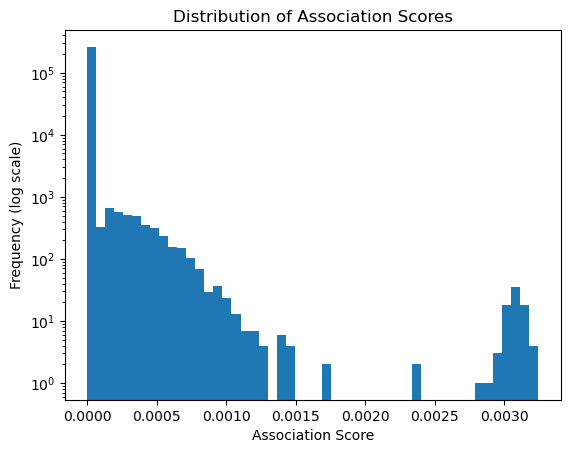

In [16]:
import matplotlib.pyplot as plt

plt.hist(M.flatten(), bins=50, log=True)
plt.title('Distribution of Association Scores')
plt.xlabel('Association Score')
plt.ylabel('Frequency (log scale)')
plt.show()

In [17]:
threshold = np.mean(M.flatten())
violation_threshold=threshold
print(violation_threshold)

6.5611657e-06


**Identify Highly Associated Words**

The identify_high_attention_pairs function aims to find pairs of tokens in an input row that receive high attention weights, indicating a strong association according to the model’s attention mechanism. This module analyzes the attention matrix from the previous module to identify these pairs to return token pairs with attention weights above a specified threshold.

In [18]:
def identify_high_attention_pairs(attention_matrix, tokens):
    high_attention_pairs = []
    seq_len = attention_matrix.shape[0]
    
    for i in range(seq_len):
        for j in range(i + 1, seq_len):  
            if attention_matrix[i, j] > threshold:  
                token1, token2 = tokens[i], tokens[j]
                if token1 not in ['[PAD]', '[SEP]', '[CLS]'] and token2 not in ['[PAD]', '[SEP]', '[CLS]']:  # Filter out special tokens if present
                    high_attention_pairs.append((token1, token2))
    
    return high_attention_pairs

In [19]:
import torch
import torch.nn.functional as F

def process_test_sentence(sentence):
    predicted_class, predicted_prob, attentions = get_prediction_attention(sentence)
    inputs = custom_tokenizer([sentence])
    token_ids = inputs['input_ids'][0]
    tokens = [id_to_token.get(id, "<UNK>") for id in token_ids]  
    
    if predicted_class == 0 and not ("<OOV>" in tokens):
        return "normal", []

    attention_matrix = attentions[-1].squeeze(0).mean(dim=0).cpu().numpy()
    
    high_attention_pairs = identify_high_attention_pairs(attention_matrix, tokens)
    
    return "anomalous", high_attention_pairs

**Check for association rule violations**

After identifying high-attention pairs in a test row deemed anomalous, this module compare these pairs against the association matrix 𝑀 to identify rule violations based on a threshold value.

In [20]:
def check_association_violations(high_attention_pairs, association_matrix, violation_threshold=violation_threshold):
    violations = []
    matrix_size = vocab_size

    for word1, word2 in high_attention_pairs:
        id1 = vocab.get(word1, vocab["<OOV>"])  
        id2 = vocab.get(word2, vocab["<OOV>"])

        if id1 < matrix_size and id2 < matrix_size:
            if association_matrix[id1, id2] < violation_threshold or word1 == "<OOV>" or word2 == "<OOV>":
                violations.append((word1, word2))
        else:
            print(f"Skipping pair ({word1}, {word2}) with IDs ({id1}, {id2}) outside association matrix bounds.")

    return violations

## Mutation Analysis
To perform mutation analysis on the dataset and calculate the mutation score, we follow these steps. The code will select 5% of the normal data, randomly mutate two column values per row, and then check if these mutations lead to the data being classified as anomalous and whether the mutated pairs are in the set of violations. The mutation score is calculated as the ratio of mutants killed (those that result in anomalies with violations) to the total number of mutants.



In [21]:
import random
import pandas as pd

normal_data = df[df['Class'] == 0].sample(frac=0.05)

def mutate_sentence(sentence):
    columns = sentence.split('],[')
    if columns:
        columns[0] = columns[0][1:]  
        columns[-1] = columns[-1][:-1]  
    
    mutation_indices = random.sample(range(len(columns)), 2)
    mutated_columns = [] 
    
    for idx in mutation_indices:
        col_val_split = columns[idx].split(':')
        col = col_val_split[0]
        mutated_val = str(random.randint(1,2))
        

        columns[idx] = f"{col}:{mutated_val}"
        mutated_columns.append(f"[{col}:{mutated_val}]")  
    
    mutated_sentence = '[' + '],['.join(columns) + ']'
    return mutated_sentence, mutated_columns

killed_mutants_1 = 0
killed_mutants_2 = 0
total_mutants = len(normal_data) 
for sentence in normal_data['sentence']:
    mutated_sentence, mutated_columns = mutate_sentence(sentence)

    status, high_attention_pairs = process_test_sentence(mutated_sentence)
    print(f"Status: {status}")
    if status == "anomalous":
        print("Highly associated words based on attention:", high_attention_pairs)
        killed_mutants_1 += 1
        violations = check_association_violations(high_attention_pairs, M)
        if violations:
            print("Violations of association rules found:", violations)
            if any("<OOV>" in pair for violation in violations for pair in violation) or any(col in pair for violation in violations for pair in violation for col in mutated_columns):
               killed_mutants_2 += 1

        else:
            print("No violations of association rules.")
    else:
        print("Sentence is normal.")

mutation_score_1 = (killed_mutants_1 / total_mutants) * 100
mutation_score_2 = (killed_mutants_2 / total_mutants) * 100
print(f"Mutation Score for anomaly detection: {mutation_score_1:.2f}%")
print(f"Mutation Score for violation detection: {mutation_score_2:.2f}%")

Status: normal
Sentence is normal.
Status: normal
Sentence is normal.
[Madh:2]
[Madh:2]
Status: anomalous
Highly associated words based on attention: [('[CT:1]', '[UCSi:7]'), ('[CT:1]', '[UCSh:7]'), ('[CT:1]', '<OOV>'), ('[CT:1]', '[SECS:8]'), ('[CT:1]', '[BN:5]'), ('[CT:1]', '[BC:7]'), ('[CT:1]', '[NN:1]'), ('[CT:1]', '[Mi:3]'), ('[UCSi:7]', '[UCSh:7]'), ('[UCSi:7]', '<OOV>'), ('[UCSi:7]', '[SECS:8]'), ('[UCSi:7]', '[BN:5]'), ('[UCSi:7]', '[BC:7]'), ('[UCSi:7]', '[NN:1]'), ('[UCSi:7]', '[Mi:3]'), ('[UCSh:7]', '<OOV>'), ('[UCSh:7]', '[SECS:8]'), ('[UCSh:7]', '[BN:5]'), ('[UCSh:7]', '[BC:7]'), ('[UCSh:7]', '[NN:1]'), ('[UCSh:7]', '[Mi:3]'), ('<OOV>', '[SECS:8]'), ('<OOV>', '[BN:5]'), ('<OOV>', '[BC:7]'), ('<OOV>', '[NN:1]'), ('<OOV>', '[Mi:3]'), ('[SECS:8]', '[BN:5]'), ('[SECS:8]', '[BC:7]'), ('[SECS:8]', '[NN:1]'), ('[SECS:8]', '[Mi:3]'), ('[BN:5]', '[BC:7]'), ('[BN:5]', '[NN:1]'), ('[BN:5]', '[Mi:3]'), ('[BC:7]', '[NN:1]'), ('[BC:7]', '[Mi:3]'), ('[NN:1]', '[Mi:3]')]
Violations of ass

## Compare with other models

Our study involves a comprehensive comparison of the proposed model against traditional anomaly detection methods, including Long Short-Term Memory (LSTM) networks and Multi-Layer Perceptrons (MLP).

In [22]:
# LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score

import time

start_time = time.time()

max_words = 5000  
max_len = 50  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_sentences)
sequences = tokenizer.texts_to_sequences(train_sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
lstm_model.fit(padded_sequences, train_labels, batch_size=32, epochs=10, validation_split=0.1, callbacks=[early_stopping])

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_len)
val_labels = np.array(val_labels)

lstm_preds = (lstm_model.predict(val_padded_sequences) > 0.5).astype('int32').flatten()

lstm_accuracy = accuracy_score(val_labels, lstm_preds)
lstm_f1 = f1_score(val_labels, lstm_preds, average='micro')

end_time = time.time()
total_time = end_time - start_time
print(f"Time taken: {total_time:.2f} seconds")


Epoch 1/10


/Users/uriel/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6264 - loss: 0.6302 - val_accuracy: 0.7581 - val_loss: 0.3994
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8807 - loss: 0.2754 - val_accuracy: 0.9677 - val_loss: 0.1386
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9535 - loss: 0.1360 - val_accuracy: 0.9677 - val_loss: 0.1240
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9602 - loss: 0.1182 - val_accuracy: 0.9839 - val_loss: 0.0696
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9523 - loss: 0.1489 - val_accuracy: 0.9677 - val_loss: 0.1402
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9653 - loss: 0.1058 - val_accuracy: 0.9677 - val_loss: 0.0996
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9657 - loss: 0.1025 - val_accuracy: 0.9677 - val_loss: 0.0775
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Time taken: 4.27 seconds


In [23]:
# MLP

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

import time

start_time = time.time()

X = df.drop(['Class','sentence'], axis=1).values
y = df['Class'].values

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_standardized, y, test_size=0.1, random_state=42)

mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(1, activation='sigmoid'))

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
mlp_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[early_stopping])

mlp_preds = (mlp_model.predict(X_val) > 0.5).astype('int32').flatten()

mlp_accuracy = accuracy_score(y_val, mlp_preds)
mlp_f1 = f1_score(y_val, mlp_preds, average='micro')

end_time = time.time()
total_time = end_time - start_time
print(f"Time Taken:{total_time:.2f} seconds")

/Users/uriel/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4253 - loss: 0.7822 - val_accuracy: 0.9677 - val_loss: 0.4759
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8325 - loss: 0.5005 - val_accuracy: 0.9677 - val_loss: 0.3074
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9140 - loss: 0.3601 - val_accuracy: 0.9677 - val_loss: 0.2110
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9212 - loss: 0.2726 - val_accuracy: 0.9677 - val_loss: 0.1521
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9524 - loss: 0.1989 - val_accuracy: 0.9677 - val_loss: 0.1247
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9529 - loss: 0.1658 - val_accuracy: 0.9677 - val_loss: 0.1153
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9635 - loss: 0.1567 - val_accuracy: 0.9677 - val_loss: 0.1131
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9603 - loss: 0.1625 - val_accuracy: 0.9677 - v

In [24]:
comparison_dict = {
    'Model': ['BERT', 'LSTM','MLP'],
    'Accuracy': [bert_accuracy, lstm_accuracy,mlp_accuracy],
    'F1 Score': [bert_f1, lstm_f1, mlp_f1]
}

comparison_df = pd.DataFrame(comparison_dict)
comparison_df

,Model,Accuracy,F1 Score
0,BERT,0.971014,0.971014
1,LSTM,0.985507,0.985507
2,MLP,0.971014,0.971014
